In [1]:
pip install statsmodels

You should consider upgrading via the '/Users/stefanroth/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LinearRegression

# from statsmodels.api import OLS, add_constant, qqplot
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_pacf

# Set figure size to (14,6)
plt.rcParams['figure.figsize'] = (14,6)

# AR - Autoregressive Model

## 1) Load the data - IMPORTANT: flights_remainder.csv!

In [53]:
df = pd.read_csv('flights_remainder.csv', index_col=0, parse_dates=True)
df.head()

,remainder
date,
1949-01-01,4.405303
1949-02-01,17.496212
1949-03-01,7.496212
1949-04-01,9.587121
1949-05-01,-5.231061


In [4]:
# Plot the data
def plot_remainder(df, title='Remaining Passenger Number after modelling Trend and Seasonality'):
    '''
    Custom plotting function for plotting the flights dataset
    
    Parameters
    ----------
    df : pd.DataFrame
        The data to plot.
    title : str
        The title of the plot
    ylim : bool
        Whether to fix the minimum value of y; defalut is True
    
    Returns
    -------
    Plots the data
    '''
    df.plot()
    plt.title(title)
    plt.ylabel('# of Passengers in 1000')
    plt.show()

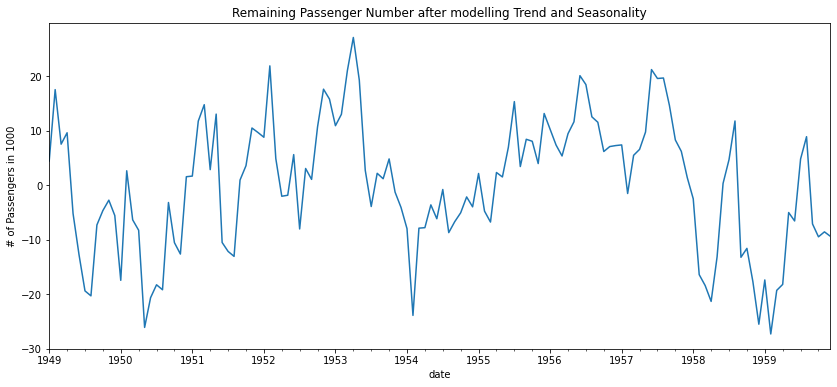

In [5]:
# Plot the remainder
plot_remainder(df['remainder'])

## 2) Create a time-lagged input feature: lag1

A lag is an interval of time between two related phenomena. The two related phenomena in this case are the remainder today and the remainder tomorrow.

In [54]:
df['lag1'] = df['remainder'].shift(1)

In [7]:
df.head()

,remainder,lag1
date,,
1949-01-01,4.405303,NaN
1949-02-01,17.496212,4.405303
1949-03-01,7.496212,17.496212
1949-04-01,9.587121,7.496212
1949-05-01,-5.231061,9.587121


## 3) Inspect correlations

In [12]:
df[['remainder']].corrwith(df['lag1'])

remainder    0.758226
dtype: float64

In [13]:
correlation = round(df.corr(), 2)

<AxesSubplot:>

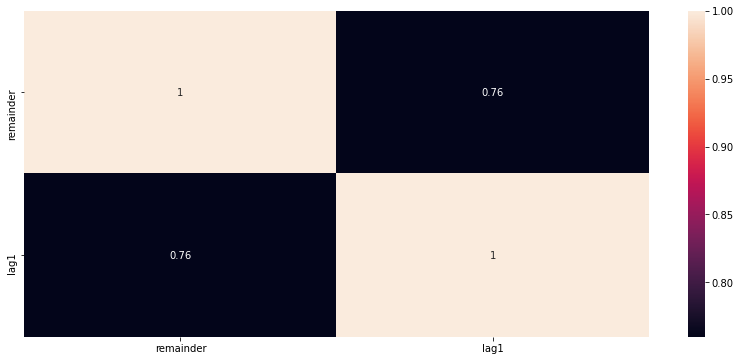

In [14]:
sns.heatmap(correlation, annot=True)

#### Intuitively

- If there were more passengers than expected by taking into accoutn trend and seasonality last month, we also expect the number of passengers to exceed trend and seasonality this month.

- If it was warmer (or colder) than expected yesterday, it is likely to be warmer (or colder) than expected today.

## 4) Plot remainder against lag1

<AxesSubplot:xlabel='lag1', ylabel='remainder'>

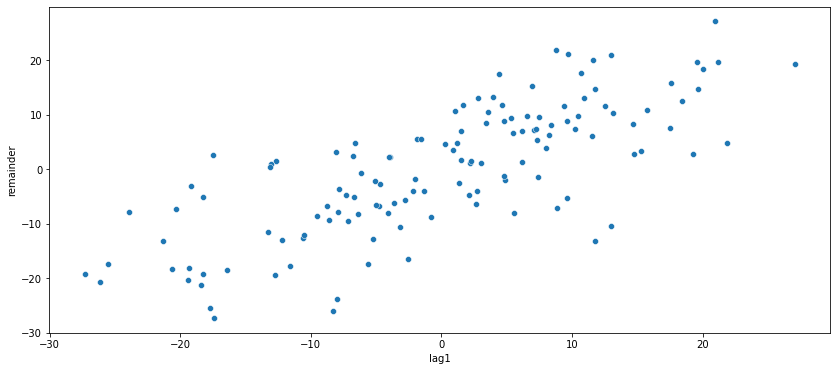

In [15]:
# Create a scatterplot
sns.scatterplot(x='lag1', y='remainder', data=df)

# AR - Autoregressive Model

Now we are ready to talk about the autoregressive model. In the autoregressive model we model the future value of a variable by looking at the present (and maybe past) value of the same variable. In our case the variable will be the **remainder**.

$$
y_{t+1} = w_0 + \sum_{j=0}^{P-1}w_{j}y_{t-j} + \epsilon_t
$$

where $t$ is the current timestep, $w_0$ is the bias/intercept, the w’s are the weights of the model and $\epsilon$ is some iid (e.g. Gaussian) noise. **P** is the number of lags to use for the model. It is a hyperparameter that we have to choose.

**AR(1) - Model**

$$
\hat{y_{t+1}} = w_0 + w_1 * y_{t}
$$

or in case of our remainder

$$
\hat{remainder_{t+1}} = w_0 + w_1 * remainder_{t}
$$

In an AR(1) model we model the value in $t+1$ as a linear function of the value in $t$.

**AR(2) - Model**

$$
\hat{y_{t+1}} = w_0 + w_1 * y_{t} + w_2 * y_{t-1}
$$

# 5) Run an Autoregressive Model (Linear Regression) of lag1 on the remainder

In [18]:
# Drop missing values
df.dropna(inplace=True)
df.head()

,remainder,lag1
date,,
1949-02-01,17.496212,4.405303
1949-03-01,7.496212,17.496212
1949-04-01,9.587121,7.496212
1949-05-01,-5.231061,9.587121
1949-06-01,-12.776515,-5.231061


In [19]:
# Assign X and y
X = df[['lag1']]
y = df['remainder']

In [20]:
# Create and fit the model
m = LinearRegression()
m.fit(X, y)

LinearRegression()

In [21]:
# Create predictions
df['predictions_ar1'] = m.predict(X)
df.head()

,remainder,lag1,predictions_ar1
date,,,
1949-02-01,17.496212,4.405303,3.258369
1949-03-01,7.496212,17.496212,13.203025
1949-04-01,9.587121,7.496212,5.606413
1949-05-01,-5.231061,9.587121,7.194795
1949-06-01,-12.776515,-5.231061,-4.062003


In [24]:
df.shape

(131, 3)

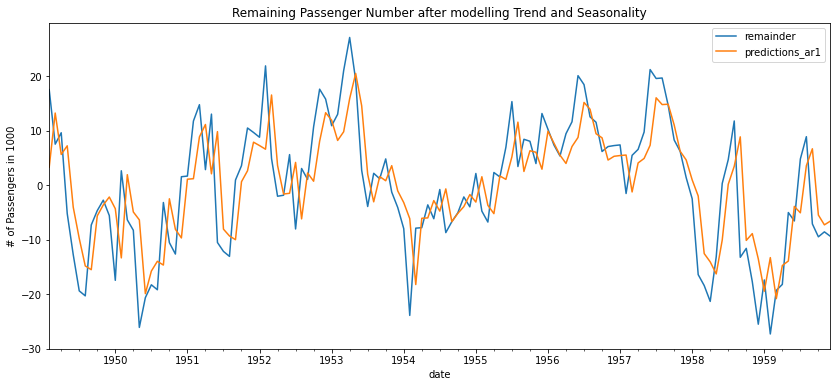

In [25]:
# Plot the original remainder and the prediction
plot_remainder(df[['remainder', 'predictions_ar1']])

In [26]:
# What is the residual compared to the remainder?
df['residual'] = df['remainder'] - df['predictions_ar1']
df.head()

,remainder,lag1,predictions_ar1,residual
date,,,,
1949-02-01,17.496212,4.405303,3.258369,14.237843
1949-03-01,7.496212,17.496212,13.203025,-5.706813
1949-04-01,9.587121,7.496212,5.606413,3.980709
1949-05-01,-5.231061,9.587121,7.194795,-12.425856
1949-06-01,-12.776515,-5.231061,-4.062003,-8.714512


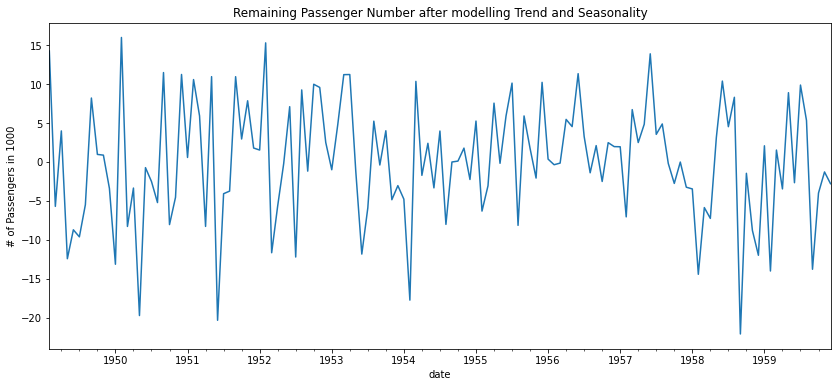

In [27]:
# Plot the residual
plot_remainder(df['residual'])

# 6) Should we add lag2?

How could we find out?

In [55]:
# Create a second lag
df['lag2'] = df.remainder.shift(2)
df.head()

,remainder,lag1,lag2
date,,,
1949-01-01,4.405303,NaN,NaN
1949-02-01,17.496212,4.405303,NaN
1949-03-01,7.496212,17.496212,4.405303
1949-04-01,9.587121,7.496212,17.496212
1949-05-01,-5.231061,9.587121,7.496212


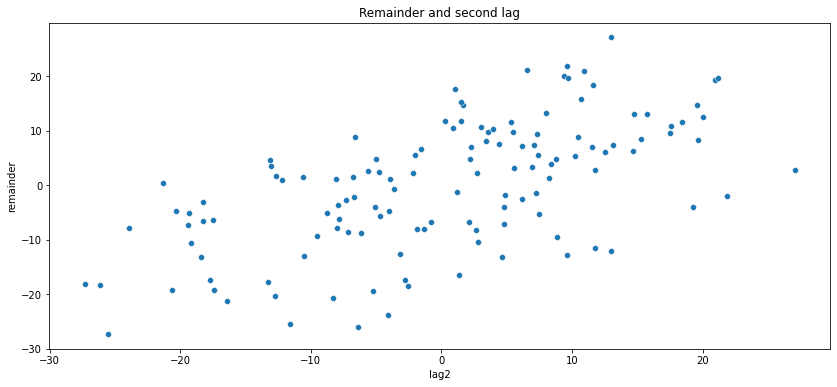

In [33]:
# Plot the second lag against the remainder
sns.scatterplot(x='lag2', y='remainder', data=df)
plt.title('Remainder and second lag')
plt.show()

Is this relationship meaningful?

<AxesSubplot:>

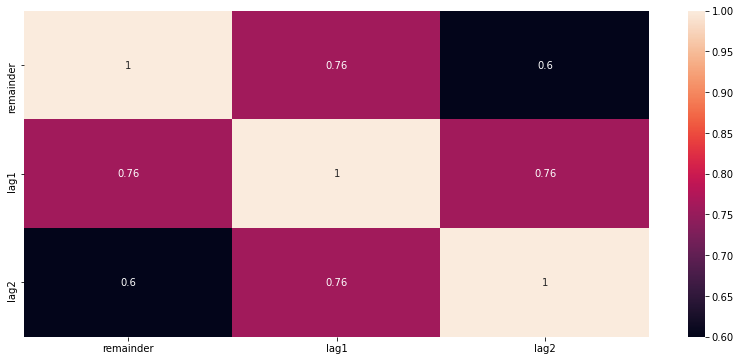

In [34]:
# Inspect correlations
correlations = round(df.corr(), 2)
sns.heatmap(correlations, annot=True)

In [35]:
# The correlation of the remainder and lag2 can be almost completely explained by the correlation between the remainder and lag1 and the
# correlation between lag1 and lag2
0.76*0.76

0.5776

## 6.1) Partial Autocorrelation

One tool to find out how many lags we should include into our Autoregressive Model is to plot the Partial Autocorrelation between different lags. What is the Partial Autocorrelation?

$$
\delta_h = Corr(y_t, y_{t-h}|y_{t-1}, ..., y_{t-h+1})
$$

A measure of time dependence is the so-called partial-autocorrelation function (PACF), which is the correlation between $y_t$ and $y_{t−h}$, conditional on the intermediate values (eg. $y_{t-1}$, $y_{t-2}$, ...).

They are basically nothing else than the coefficients in a linear regression if you included h lags.

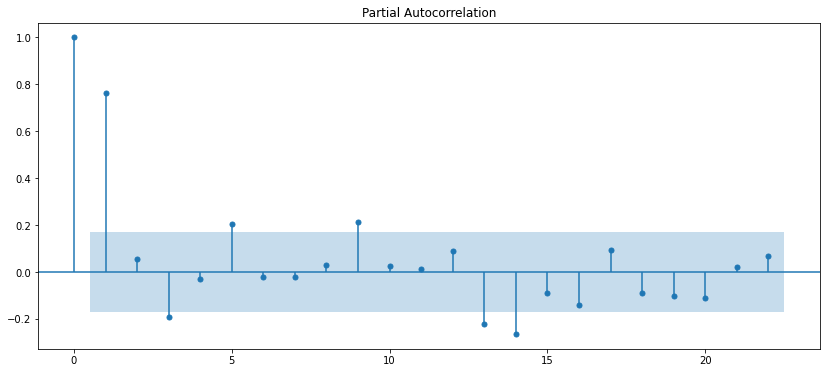

In [36]:
# Statsmodels provides a function called plot_pacf
# plot partial autocorrelation function
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df['remainder']);

**Box-Jenkins-Methodology:**

This methodology makes a statement about how to choose lags.

We will choose all lags until the first partial autocorrelation value ends up within the confidence interval. In this case we will have 1 lag.

## 6.2) Introduce statsmodels and ar_select_order

In [75]:
# Let ar_select_order select the number of lags for the remainder
selected_order = ar_select_order(endog=df['remainder'], maxlag=12, old_names=False)

/Users/stefanroth/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/stefanroth/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [43]:
# Inspect the number of lags chosen
selected_order.ar_lags

# The evaluation metric that the ar_select_order uses to choose the best model is the BIC or Bayes Information Criterion
# Tomorrow or on Thursday afternoon you will probably see the AIC (Akaike Information Criterion) which measures something similar to 
# the BIC

array([1])

In [71]:
# statsmodels also has an AutoReg which does a bit of the modelling for you
# Only use this if you feel comfortable
from statsmodels.tsa.ar_model import AutoReg

ar_model = AutoReg(endog=df['remainder'], lags=2).fit()
# endog in statsmodels is y in sklearn. df['remainder'] is our y, that we want to predict

/Users/stefanroth/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/stefanroth/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


In [72]:
# Look at the model summary
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              remainder   No. Observations:                  130
Model:                     AutoReg(2)   Log Likelihood                -442.702
Method:               Conditional MLE   S.D. of innovations              7.688
Date:                Tue, 27 Apr 2021   AIC                              4.142
Time:                        15:41:26   BIC                              4.231
Sample:                    05-01-1949   HQIC                             4.178
                         - 12-01-1959                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       -0.1904      0.680     -0.280      0.779      -1.522       1.142
remainder.L1     0.7211      0.088      8.173      0.000       0.548       0.894
remainder.L2     0.0512      0.088      0.580      0.562      -0.122       0.224
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2720           +0.0000j            1.2720            0.0000
AR.2          -15.3561           +0.0000j           15.3561            0.5000
-----------------------------------------------------------------------------
"""

# What now?

- This afternoon we completely focused on modelling the remainder separate from everything else.
- In the end we are still interested in the absolut number of passengers (or temperature), not in the remainder itself

Next step: Add the lag of the original variable (or the remainder) as a feature to your DataFrame and create a new model with the features timestep, seasonal_dummies and the appropriate number of lags

# Excurse

In [66]:
m = LinearRegression()
df.dropna(inplace=True)
m.fit(df[['lag1']], df['remainder'])

LinearRegression()

In [67]:
df['predictions_ar1'] = m.predict(df[['lag1']])
df.head()

,remainder,lag1,lag2,predictions_ar1,residual
date,,,,,
1949-03-01,7.496212,17.496212,4.405303,13.034350,-5.538138
1949-04-01,9.587121,7.496212,17.496212,5.471621,4.115500
1949-05-01,-5.231061,9.587121,7.496212,7.052919,-12.283980
1949-06-01,-12.776515,-5.231061,9.587121,-4.153670,-8.622845
1949-07-01,-19.412879,-12.776515,-5.231061,-9.860093,-9.552786


In [68]:
df['residual'] = df['remainder'] - df['predictions_ar1']

<AxesSubplot:>

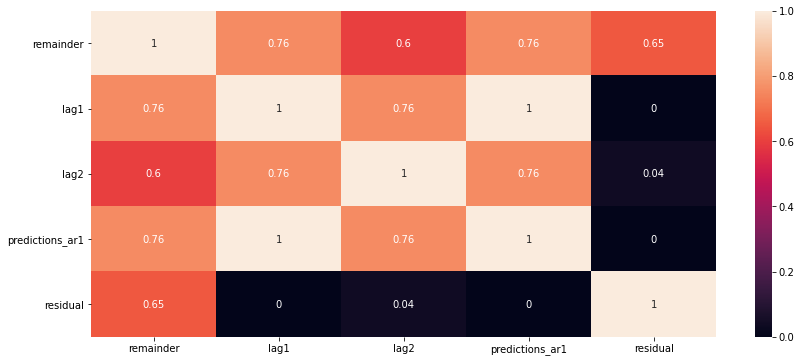

In [69]:
sns.heatmap(round(df.corr(), 2), annot=True)

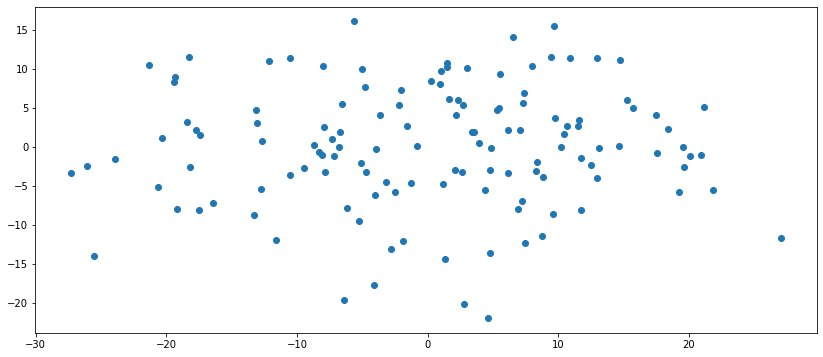

In [70]:
plt.scatter(x='lag2', y='residual', data=df)